In [24]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
import itertools

import pandas as pd
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

from concurrent.futures import ThreadPoolExecutor
from threading import Lock

In [25]:
# Load CSV files into DataFrames with encoding specification
people_df = pd.read_csv("lahman_1871-2023_csv/People.csv", encoding='latin1')
batting_df = pd.read_csv("lahman_1871-2023_csv/Batting.csv", encoding='latin1')
pitching_df = pd.read_csv("lahman_1871-2023_csv/Pitching.csv", encoding='latin1')
fielding_df = pd.read_csv("lahman_1871-2023_csv/Fielding.csv", encoding='latin1')
awards_players_df = pd.read_csv("lahman_1871-2023_csv/AwardsPlayers.csv", encoding='latin1')
hall_of_fame_df = pd.read_csv("lahman_1871-2023_csv/HallOfFame.csv", encoding='latin1')
all_star_df = pd.read_csv("lahman_1871-2023_csv/AllStarFull.csv", encoding='latin1')
teams_df = pd.read_csv("lahman_1871-2023_csv/Teams.csv", encoding='latin1')
appearances_df = pd.read_csv("lahman_1871-2023_csv/Appearances.csv", encoding='latin1')
#college_playing_df = pd.read_csv("lahman_1871-2023_csv/CollegePlaying.csv", encoding='latin1')
len(people_df)

21010

In [26]:
len(hall_of_fame_df[hall_of_fame_df['inducted'] == 'Y']['playerID'].unique())



357

In [27]:
# Initialize a DataFrame with playerID as the primary feature
features = pd.DataFrame(appearances_df['playerID'])
# Ensure playerID is distinct in the features DataFrame
features = features.drop_duplicates(subset=['playerID'])


# Merge appearances with teams
merged = pd.merge(appearances_df, teams_df, on=['yearID', 'teamID'])

# Count wins during player's tenure
results = merged.groupby(['playerID', 'teamID']).agg(
    division_wins=pd.NamedAgg(column='DivWin', aggfunc=lambda x: (x == 'Y').sum()),
    wild_card_wins=pd.NamedAgg(column='WCWin', aggfunc=lambda x: (x == 'Y').sum()),
    league_titles=pd.NamedAgg(column='LgWin', aggfunc=lambda x: (x == 'Y').sum()),
    world_series_titles=pd.NamedAgg(column='WSWin', aggfunc=lambda x: (x == 'Y').sum())
).reset_index()

# Aggregate the results by playerID
player_wins = results.groupby('playerID')[['division_wins', 'wild_card_wins', 'league_titles', 'world_series_titles']].sum().reset_index()

# Merge the aggregated results into the features DataFrame
features = features.merge(player_wins, on='playerID', how='left')


# Aggregate total wins, games, and IPouts for each player from the pitching data
pitchers = pitching_df.groupby('playerID')[['W', 'G', 'IPouts']].sum().reset_index()
features = features.merge(pitchers, on='playerID', how='left')
features.rename(columns={'W': 'tot_wins', 'G': 'tot_games_pitched', 'IPouts': 'tot_ipouts'}, inplace=True)

# Calculate win rate for each player and merge into features
features['win_rate'] = features['tot_wins'] / features['tot_games_pitched']
features['win_rate'].replace([float('inf'), -float('inf')], float('nan'), inplace=True)

# Aggregate total hits, RBIs, and home runs for each player from the batting data and merge into features
batters = batting_df.groupby('playerID')[['H', 'RBI', 'HR']].sum().reset_index()
features = features.merge(batters, on='playerID', how='left')
features.rename(columns={'H': 'tot_hits', 'RBI': 'tot_rbi', 'HR': 'tot_hr'}, inplace=True)

# Calculate average hits for each player and merge into features
batting_df['average_hits'] = batting_df['H'] / batting_df['G']
batting_df.replace([float('inf'), -float('inf')], float('nan'), inplace=True)
average_hits = batting_df.groupby('playerID')['average_hits'].mean().reset_index()
features = features.merge(average_hits, on='playerID', how='left')

# Convert debut and final game dates to datetime format for calculation
people_df['debut'] = pd.to_datetime(people_df['debut'], errors='coerce')
people_df['finalGame'] = pd.to_datetime(people_df['finalGame'], errors='coerce')

# Calculate total years played by subtracting debut year from final game year
people_df['total_years'] = people_df['finalGame'].dt.year - people_df['debut'].dt.year

# Merge the total_years column into the features DataFrame
features = features.merge(people_df[['playerID', 'total_years']], on='playerID', how='left')

# Determine if it has been 5 years since a player's retirement
current_year = pd.Timestamp.now().year
people_df['retirement_5years'] = ((current_year - people_df['finalGame'].dt.year) >= 5).astype(int)

# Merge the retirement_5years column into the features DataFrame
features = features.merge(people_df[['playerID', 'retirement_5years']], on='playerID', how='left')

# Aggregate total strikeouts for each player from the pitching data and merge into features
strikeouts = pitching_df.groupby('playerID')['SO'].sum().reset_index()
features = features.merge(strikeouts, on='playerID', how='left')
features.rename(columns={'SO': 'tot_strikeouts'}, inplace=True)

# Calculate batting average for each player and merge into features
batting_df['batting_average'] = batting_df['H'] / batting_df['AB']
batting_df.replace([float('inf'), -float('inf')], float('nan'), inplace=True)
batting_average = batting_df.groupby('playerID')['batting_average'].mean().reset_index()
features = features.merge(batting_average, on='playerID', how='left')

# Calculate on-base percentage (OBP) for each player and merge into features
batting_df['OBP'] = (batting_df['H'] + batting_df['BB'] + batting_df['HBP']) / (batting_df['AB'] + batting_df['BB'] + batting_df['HBP'] + batting_df['SF'])
batting_df.replace([float('inf'), -float('inf')], float('nan'), inplace=True)
obp = batting_df.groupby('playerID')['OBP'].mean().reset_index()
features = features.merge(obp, on='playerID', how='left')

# Calculate Earned Run Average (ERA) for each player and merge into features
pitching_df['ERA'] = (pitching_df['ER'] * 3) / pitching_df['IPouts']
pitching_df.replace([float('inf'), -float('inf')], float('nan'), inplace=True)
era = pitching_df.groupby('playerID')['ERA'].mean().reset_index()
features = features.merge(era, on='playerID', how='left')

# Calculate Walks plus Hits per Inning Pitched (WHIP) for each player and merge into features
pitching_df['WHIP'] = (pitching_df['BB'] + pitching_df['H']) / (pitching_df['IPouts'] / 3)
pitching_df.replace([float('inf'), -float('inf')], float('nan'), inplace=True)
whip = pitching_df.groupby('playerID')['WHIP'].mean().reset_index()
features = features.merge(whip, on='playerID', how='left')

# Aggregate putouts (PO), assists (A), and double plays (DP) for each player from the fielding data and merge into features
fielding_sum = fielding_df.groupby('playerID')[['PO', 'A', 'DP']].sum().reset_index()

# Calculate average errors (E) and zone rating (ZR) for each player and merge into features
fielding_avg = fielding_df.groupby('playerID')[['E', 'ZR']].mean().reset_index()

# Merge the aggregated and average fielding data into the features DataFrame
features = features.merge(fielding_sum, on='playerID', how='left')
features = features.merge(fielding_avg, on='playerID', how='left')

# Aggregate the number of awards each player received from the awards_players table and merge into features
awards_count = awards_players_df.groupby('playerID').size().reset_index(name='total_awards')
features = features.merge(awards_count, on='playerID', how='left')
features['total_awards'].fillna(0, inplace=True)

# Aggregate the number of All-Star game appearances for each player from the AllStarFull table and merge into features
all_star_appearances = all_star_df.groupby('playerID').size().reset_index(name='all_star_appearances')
features = features.merge(all_star_appearances, on='playerID', how='left')
features['all_star_appearances'].fillna(0, inplace=True)

# Display the first 3 rows of the features DataFrame for verification
len(features)


C:\Users\WOOLRARAS\AppData\Local\Temp\ipykernel_19788\2566537721.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  features['win_rate'].replace([float('inf'), -float('inf')], float('nan'), inplace=True)
C:\Users\WOOLRARAS\AppData\Local\Temp\ipykernel_19788\2566537721.py:104: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are

20731

In [28]:
# Create a DataFrame that shows the number of games played as a batter, pitcher, and fielder for each player
games_batting = batting_df.groupby('playerID')['G'].sum().reset_index()
games_pitching = pitching_df.groupby('playerID')['G'].sum().reset_index()
games_fielding = fielding_df.groupby('playerID')['G'].sum().reset_index()

# Rename the columns to distinguish between batting, pitching, and fielding games
games_batting.rename(columns={'G': 'G_batting'}, inplace=True)
games_pitching.rename(columns={'G': 'G_pitching'}, inplace=True)
games_fielding.rename(columns={'G': 'G_fielding'}, inplace=True)

# Merge the game counts into a single DataFrame
games_df = games_batting.merge(games_pitching, on='playerID', how='outer')
games_df = games_df.merge(games_fielding, on='playerID', how='outer')

# Fill NaN values with 0
games_df.fillna(0, inplace=True)

# Calculate the total number of games played by each player
games_df['total_games'] = games_df['G_batting'] + games_df['G_pitching'] + games_df['G_fielding']

# Calculate the ratio of games played in each role
games_df['ratio_batting'] = games_df['G_batting'] / games_df['total_games']
games_df['ratio_pitching'] = games_df['G_pitching'] / games_df['total_games']
games_df['ratio_fielding'] = games_df['G_fielding'] / games_df['total_games']

# Determine the type of player based on the highest game ratio
def determine_player_type(row):
    if row['ratio_pitching'] >= row['ratio_batting'] and row['ratio_pitching'] >= row['ratio_fielding']:
        return 1  # Pitcher
    elif row['ratio_batting'] >= row['ratio_pitching'] and row['ratio_batting'] >= row['ratio_fielding']:
        return 2  # Batter
    else:
        return 3  # Fielder

games_df['type_of_player'] = games_df.apply(determine_player_type, axis=1)

# Merge the type_of_player column into the features DataFrame
features = features.merge(games_df[['playerID', 'type_of_player']], on='playerID', how='left')
features.fillna(0, inplace=True)
# Merge the total_games column into the features DataFrame
features = features.merge(games_df[['playerID', 'total_games']], on='playerID', how='left')


# features.head(3)
features.info()
# games_df.head(3)
cleansed_df = features.copy()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20731 entries, 0 to 20730
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   playerID              20731 non-null  object 
 1   division_wins         20731 non-null  float64
 2   wild_card_wins        20731 non-null  float64
 3   league_titles         20731 non-null  float64
 4   world_series_titles   20731 non-null  float64
 5   tot_wins              20731 non-null  float64
 6   tot_games_pitched     20731 non-null  float64
 7   tot_ipouts            20731 non-null  float64
 8   win_rate              20731 non-null  float64
 9   tot_hits              20731 non-null  float64
 10  tot_rbi               20731 non-null  float64
 11  tot_hr                20731 non-null  float64
 12  average_hits          20731 non-null  float64
 13  total_years           20731 non-null  float64
 14  retirement_5years     20731 non-null  float64
 15  tot_strikeouts     

In [29]:
features['in_hall_of_fame'] = features['playerID'].isin(hall_of_fame_df['playerID']).astype(int)
features.set_index("playerID", inplace=True)
features[features['in_hall_of_fame']==True]

features.fillna(0, inplace=True)
# Shuffle the features DataFrame
features = features.sample(frac=1, random_state=42).reset_index(drop=True)

selected_columns = [
    'division_wins', 'wild_card_wins', 'league_titles', 'tot_ipouts', 'win_rate', 'tot_hits', 'tot_rbi', 'tot_hr', 'average_hits', 'retirement_5years', 'tot_strikeouts', 'batting_average', 'OBP', 'ERA', 'WHIP', 'all_star_appearances', 'in_hall_of_fame'
]

# Filter the features DataFrame to only include the selected columns
features = features[selected_columns]

features

,division_wins,wild_card_wins,league_titles,tot_ipouts,win_rate,tot_hits,tot_rbi,tot_hr,average_hits,retirement_5years,tot_strikeouts,batting_average,OBP,ERA,WHIP,all_star_appearances,in_hall_of_fame
0,0.0,0.0,0.0,0.0,0.000000,5.0,3.0,0.0,0.294118,1.0,0.0,0.135135,0.000000,0.000000,0.000000,0.0,0
1,0.0,0.0,0.0,0.0,0.000000,109.0,72.0,25.0,0.536639,1.0,0.0,0.211303,0.271290,0.000000,0.000000,0.0,0
2,6.0,2.0,4.0,0.0,0.000000,2047.0,747.0,209.0,1.200109,0.0,0.0,0.300644,0.357198,0.000000,0.000000,8.0,0
3,0.0,0.0,1.0,128.0,0.090909,3.0,1.0,0.0,0.187500,1.0,19.0,0.150000,0.000000,1.062857,2.610000,0.0,0
4,0.0,0.0,0.0,0.0,0.000000,1.0,0.0,0.0,1.000000,1.0,0.0,1.000000,1.000000,0.000000,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20726,4.0,0.0,1.0,3476.0,0.097421,2.0,0.0,0.0,0.002295,1.0,701.0,0.312500,0.312500,0.476792,1.528312,0.0,0
20727,1.0,0.0,1.0,2821.0,0.189516,27.0,6.0,0.0,0.135264,1.0,396.0,0.143752,0.179067,0.407148,1.364202,0.0,0
20728,0.0,0.0,0.0,79.0,0.000000,1.0,0.0,0.0,0.045455,1.0,10.0,0.142857,0.000000,0.414474,1.467105,0.0,0
20729,0.0,0.0,0.0,0.0,0.000000,468.0,270.0,14.0,0.886809,1.0,0.0,0.235278,0.000000,0.000000,0.000000,0.0,0


In [30]:
X_train, X_test, y_train, y_test = train_test_split(features.drop('in_hall_of_fame', axis=1), features['in_hall_of_fame'], test_size=0.2, random_state=42, stratify=features['in_hall_of_fame'])
from sklearn.feature_selection import RFE

# Initialize the model for RFE
estimator = DecisionTreeClassifier(random_state=42)

# Create a loop to test different numbers of features to select
best_f1_score = 0
best_n_features = 0
best_model = None
best_report = ""

for n_features in range(X_train.shape[1], X_train.shape[1] + 1):
    # Initialize RFE with the current number of features
    selector = RFE(estimator, n_features_to_select=n_features, step=1)
    
    # Fit the RFE model
    selector = selector.fit(X_train, y_train)
    
    # Transform the training and testing data
    X_train_rfe = selector.transform(X_train)
    X_test_rfe = selector.transform(X_test)
    
    # Initialize the classifier and grid search
    clf = DecisionTreeClassifier(random_state=42)
    param_grid = {
        'max_depth': [3, 5, 7, 8, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10, 20, 25, 30],
        'min_samples_leaf': [1, 2, 4, 8, 10],
        'criterion': ['gini', 'entropy'],
        'max_features': ['sqrt', 'log2', None],
        'class_weight': [None, 'balanced'],
        'splitter': ['best', 'random']
    }
    f1_scorer = make_scorer(f1_score)
    
    grid_search = GridSearchCV(
        estimator=clf,
        param_grid=param_grid,
        scoring=f1_scorer,
        cv=5,
        verbose=1,
        n_jobs=-1
    )
    
    # Fit the grid search
    grid_search.fit(X_train_rfe, y_train)
    current_model = grid_search.best_estimator_
    y_test_pred = current_model.predict(X_test_rfe)
    report = classification_report(y_test, y_test_pred, output_dict=True)
    current_f1_score = report['1']['f1-score']
    
    # Check if this is the best model so far
    if current_f1_score > best_f1_score:
        print(f"Best hyperparameters: {grid_search.best_params_}")
        print(f"New best F1 score: {current_f1_score} with {n_features} features")
        selected_features = X_train.columns[selector.support_]
        print(f"Selected features with {n_features} features: {selected_features}")
        best_f1_score = current_f1_score
        best_n_features = n_features
        best_model = current_model
        best_report = classification_report(y_test, y_test_pred, digits=4)

print(f"Best number of features: {best_n_features}")
print(best_report)

Fitting 5 folds for each of 5760 candidates, totalling 28800 fits
Best hyperparameters: {'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2, 'splitter': 'random'}
New best F1 score: 0.7131147540983607 with 16 features
Selected features with 16 features: Index(['division_wins', 'wild_card_wins', 'league_titles', 'tot_ipouts',
       'win_rate', 'tot_hits', 'tot_rbi', 'tot_hr', 'average_hits',
       'retirement_5years', 'tot_strikeouts', 'batting_average', 'OBP', 'ERA',
       'WHIP', 'all_star_appearances'],
      dtype='object')
Best number of features: 16
              precision    recall  f1-score   support

           0     0.9738    0.9904    0.9821      3870
           1     0.8246    0.6282    0.7131       277

    accuracy                         0.9662      4147
   macro avg     0.8992    0.8093    0.8476      4147
weighted avg     0.9639    0.9662    0.9641      4147



In [45]:
y_test_pred_best = best_model.predict(X_test)
# len(y_test_pred_best)
# y_test_pred_best
np.array(y_test)


c:\Users\WOOLRARAS\ece_356\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


array([0, 0, 0, ..., 1, 0, 0])

c:\Users\WOOLRARAS\ece_356\venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


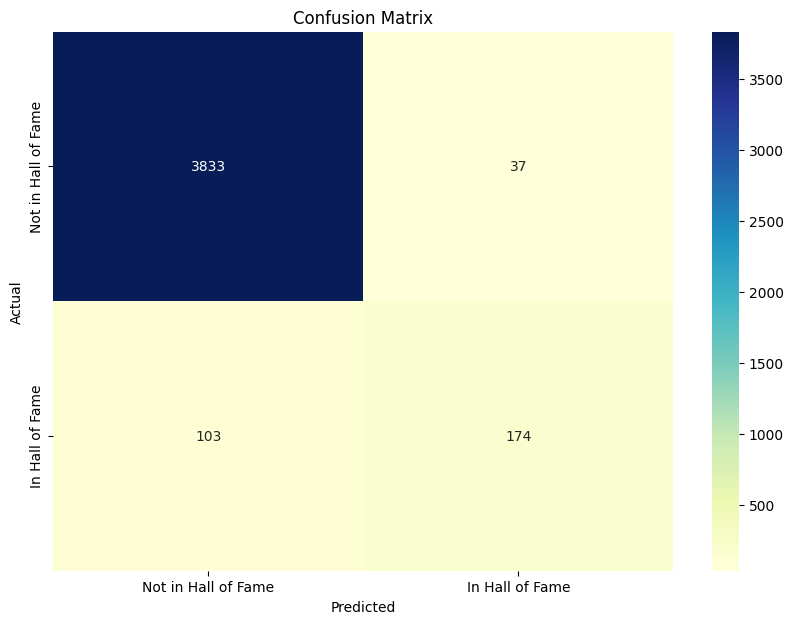

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Use the best model to predict the test set
y_test_pred_best = best_model.predict(X_test)

# Create the confusion matrix
conf_matrix = confusion_matrix(np.array(y_test), y_test_pred_best)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=['Not in Hall of Fame', 'In Hall of Fame'], yticklabels=['Not in Hall of Fame', 'In Hall of Fame'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


PART B

In [ ]:

# features.drop('in_hall_of_fame', axis=1, inplace=True)
features.columns
# Merge Hall of Fame data with features on player ID
hall_of_fame_df['inducted'] = hall_of_fame_df['inducted'].apply(lambda x: 1 if x == 'Y' else 0)
hall_of_fame_inducted = hall_of_fame_df[hall_of_fame_df['inducted'] == 1]
features = features.merge(hall_of_fame_inducted[['playerID', 'inducted']], on='playerID', how='left')
features.fillna(0, inplace=True)
features.drop('playerID', axis=1, inplace=True)
# Display the result
features[features['inducted']!=0]


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features.drop('inducted', axis=1), features['inducted'], test_size=0.2, random_state=42, stratify=features['inducted'])

estimator = DecisionTreeClassifier(random_state=42)

param_grid = {
    'max_depth': [3, 5, 7, 8, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20, 25, 30],
    'min_samples_leaf': [1, 2, 4, 8, 10],
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2', None],
    'class_weight': [None, 'balanced'],
    'splitter': ['best', 'random']
}
f1_scorer = make_scorer(f1_score)

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(X_train, y_train)
current_model = grid_search.best_estimator_
y_test_pred = current_model.predict(X_test)
report = classification_report(y_test, y_test_pred, output_dict=True)

# print(f"Best number of features: {best_n_features}")
print(report)